# Documentation

**OLR Analysis**

**Author:** Spencer Ressel

**Created:** December 10th, 2021

---

This file does analysis on the dataset of Outgoing Longwave Radiation (OLR) from Liebmann and Smith (1994)

---

# Imports

In [1]:
# Data Analysis Tools
import numpy as np
import xarray as xr
from scipy import interpolate
import scipy.fft as fft
import pandas as pd

import sys
sys.path.insert(0, '/home/disk/eos7/sressel/research/thesis-work/python/auxiliary_functions/')
import ipynb.fs.full.mjo_mean_state_diagnostics as mjo

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LongitudeLocator, LatitudeLocator

# Load data

In [3]:
# Wind data
TIME_MIN = '1999-01-01T00:00:00.000000000'
TIME_MAX = '2018-12-31T00:00:00.000000000'
LAT_MIN = -30
LAT_MAX = 30

wind_data = xr.open_dataset(
    'C:/Users/resse/Desktop/Data/ECMWF/ERA5/era5_combined_wind_daily_1979_2020_pressure_levels.nc'
).sortby('lat')

upper_level_zonal_wind = wind_data['u'].sel(time=slice(TIME_MIN, TIME_MAX), lev=200, lat=slice(LAT_MIN, LAT_MAX))
lower_level_zonal_wind = wind_data['u'].sel(time=slice(TIME_MIN, TIME_MAX), lev=850, lat=slice(LAT_MIN, LAT_MAX))
upper_level_meridional_wind = wind_data['v'].sel(time=slice(TIME_MIN, TIME_MAX), lev=200, lat=slice(LAT_MIN, LAT_MAX))
lower_level_meridional_wind = wind_data['v'].sel(time=slice(TIME_MIN, TIME_MAX), lev=850, lat=slice(LAT_MIN, LAT_MAX))


olr_data = xr.open_dataset('C:/Users/resse/Desktop/Data/NOAA/olr.day.mean.nc')
outgoing_longwave_radiation = olr_data['olr'].sortby('lat').sel(time=slice(TIME_MIN, TIME_MAX), lat=slice(LAT_MIN, LAT_MAX))

outgoing_longwave_radiation_anomalies = outgoing_longwave_radiation - outgoing_longwave_radiation.mean()
lower_level_zonal_wind_anomalies = lower_level_zonal_wind - lower_level_zonal_wind.mean()
lower_level_meridional_wind_anomalies = lower_level_meridional_wind - lower_level_meridional_wind.mean()

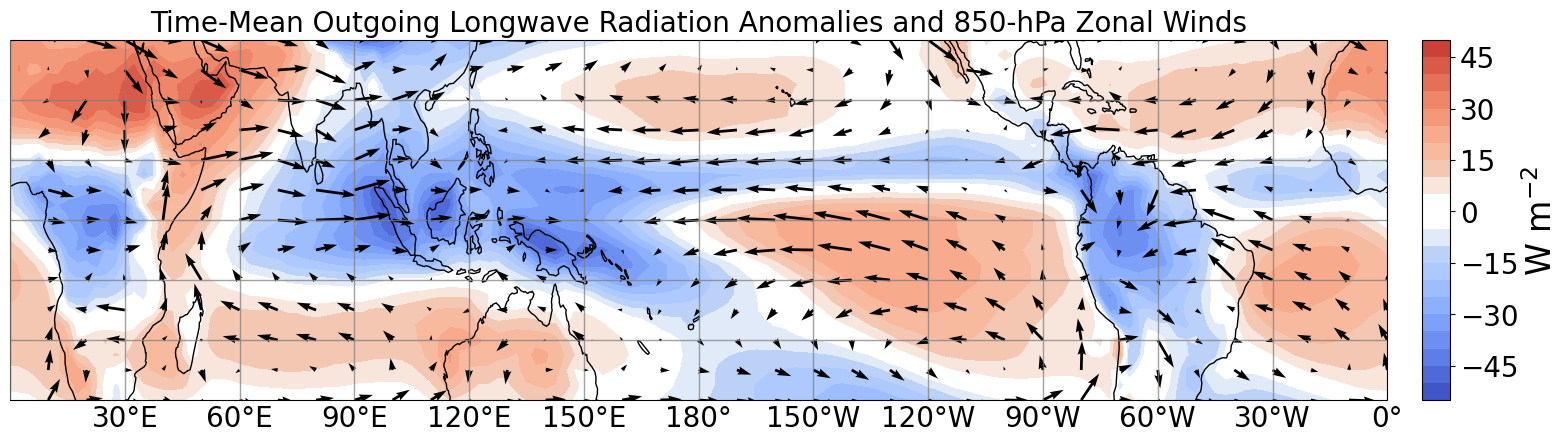

In [9]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
cmap_modified = mjo.modified_colormap('coolwarm', 'white', 0.1, 0.1)
# cmap_modified = 'BrBG'
coastline_width = 1

gs = GridSpec(1, 2, width_ratios=(1, 0.02))
gs.update(top=.95, bottom=0.05, left=0.05, right=.95, hspace=0, wspace=0.05)
f = plt.figure(figsize=(16,4))

ax = f.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=-180))
cb_ax = f.add_subplot(gs[1])

# Moisture Tendency
ax.set_title(f"Time-Mean Outgoing Longwave Radiation Anomalies and 850-hPa Zonal Winds", fontsize=20)
im = ax.contourf(
    outgoing_longwave_radiation_anomalies.lon, 
    outgoing_longwave_radiation_anomalies.lat,
    outgoing_longwave_radiation_anomalies.mean(dim='time'),
    transform=ccrs.PlateCarree(), 
    # cmap='RdYlBu_r',
    cmap=cmap_modified,
    norm=mcolors.CenteredNorm(),
    levels=21
)    

cbar = f.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'W m$^{-2}$')

# Add cyclic point
cdata, clon = cutil.add_cyclic_point(
    outgoing_longwave_radiation_anomalies.mean(dim='time'),
    coord=outgoing_longwave_radiation_anomalies.lon
)

ax.contourf(
    clon, 
    outgoing_longwave_radiation_anomalies.lat, 
    cdata, 
    transform=ccrs.PlateCarree(), 
    # cmap='RdYlBu_r',
    cmap=cmap_modified,
    norm=mcolors.CenteredNorm(),
    levels=21
)

arrow_spacing = 2
ax.quiver(
    lower_level_zonal_wind_anomalies.lon[::2*arrow_spacing],
    lower_level_zonal_wind_anomalies.lat[::arrow_spacing],
    lower_level_zonal_wind_anomalies.mean(dim='time').values[::arrow_spacing, ::2*arrow_spacing],
    lower_level_meridional_wind_anomalies.mean(dim='time').values[::arrow_spacing, ::2*arrow_spacing],
    width=0.002,
    scale=250,
    transform=ccrs.PlateCarree(central_longitude=-180)
)

ax.set_aspect('auto')
ax.set_xlabel('')
ax.add_feature(cf.COASTLINE, lw=coastline_width)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color="gray",
    alpha=0.75,
    linestyle="-",
    zorder=15

)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,30))
# gl.xlocator = LongitudeLocator(30)
gl.xformatter = LongitudeFormatter()
gl.xlabel_style = {'fontsize':20}
gl.ylocator = mticker.FixedLocator(np.arange(-40,40,10))
gl.yformatter = LatitudeFormatter()
gl.ylabel_style = {'fontsize':20}

plt.show()

# FFT of OLR

In [104]:
outgoing_longwave_radiation_time_anomaly = (
    outgoing_longwave_radiation - outgoing_longwave_radiation.mean(dim='time')
)

fft_outgoing_longwave_radiation = fft.fft2(
    outgoing_longwave_radiation_time_anomaly.mean(dim='lat').values, axes=[1]
)
fft_outgoing_longwave_radiation[:, 8:-8] = 0
intraseasonal_outgoing_longwave_radiation = (
    outgoing_longwave_radiation_time_anomaly.mean(dim='lat').copy(deep=True)
)
intraseasonal_outgoing_longwave_radiation.values = fft.ifft2(fft_outgoing_longwave_radiation, axes=[1])

mjo_filtered_outgoing_longwave_radiation = (
    outgoing_longwave_radiation_time_anomaly.mean(dim='lat').copy(deep=True)
)
mjo_filtered_outgoing_longwave_radiation.values = mjo.lanczos_bandpass_filter(
    intraseasonal_outgoing_longwave_radiation, 
    lowcut=(1/100), 
    highcut=(1/20), 
    fs=1, 
    filter_axis=0
)

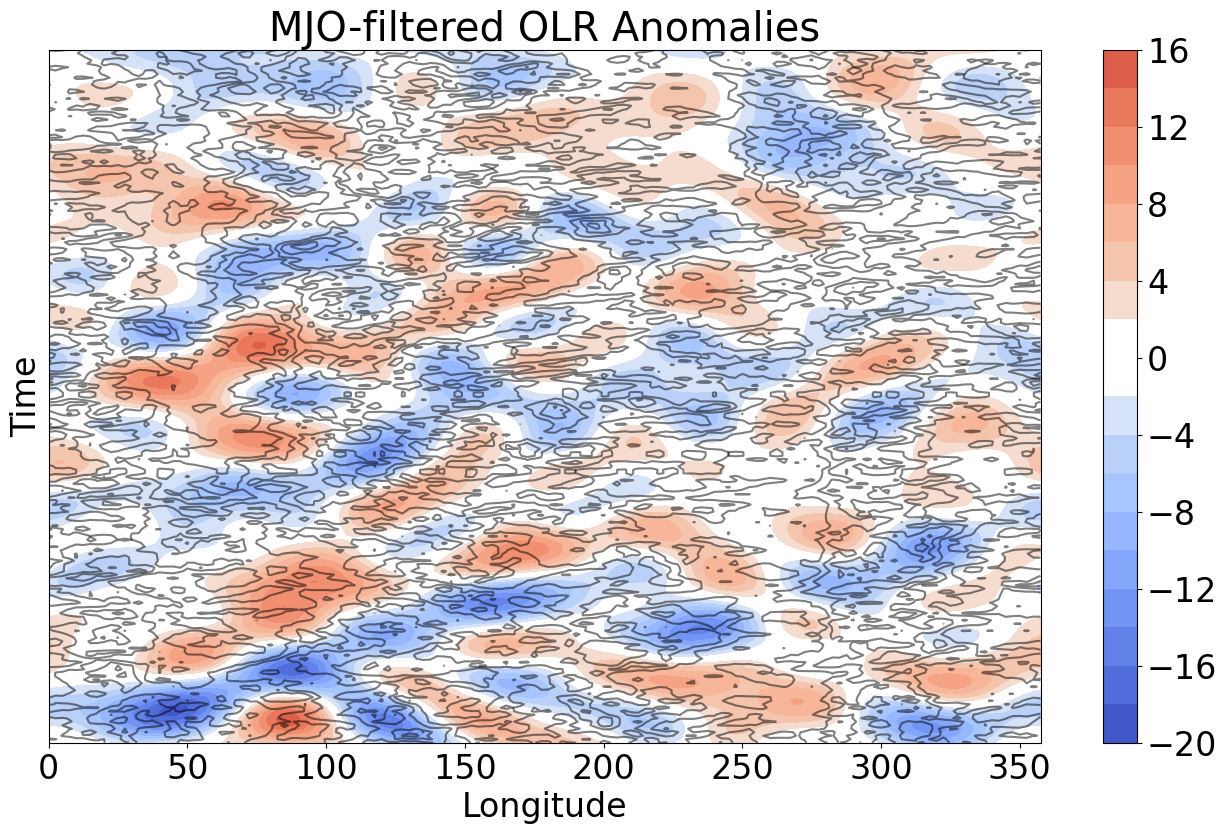

In [105]:
t_upper = 200

[fig, ax] = plt.subplots(figsize=(16,9))
ax.set_title('MJO-filtered OLR Anomalies')
im = ax.contourf(
    outgoing_longwave_radiation_time_anomaly_mjo.lon,
    outgoing_longwave_radiation_time_anomaly_mjo.time.isel(time=slice(1,t_upper)),
    np.real(mjo_filtered_outgoing_longwave_radiation.isel(time=slice(1,t_upper))),
    cmap = cmap_modified,
    norm = mcolors.CenteredNorm(),
    levels=21
)
fig.colorbar(im)

ax.contour(
    outgoing_longwave_radiation_time_anomaly_mjo.lon,
    outgoing_longwave_radiation_time_anomaly_mjo.time.isel(time=slice(1,t_upper)),
    np.real(outgoing_longwave_radiation.mean(dim='lat').isel(time=slice(1,t_upper))),
    colors = 'black',
    alpha = 0.5,
    levels=8
)

ax.set_ylabel('Time')
ax.set_xlabel('Longitude')
ax.set_yticks([])
plt.show()
